In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

# Pytorch way of data augmentation.
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split


import albumentations as A
from albumentations.pytorch import ToTensorV2
! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/segdata/metadata.csv')
df['Image'] = [os.path.join('/content/drive/MyDrive/segdata/Image', i) for i in df['Image']]
df['Mask'] = [os.path.join('/content/drive/MyDrive/segdata/Mask', i) for i in df['Mask']]
df.head()

,Image,Mask
0,/content/drive/MyDrive/segdata/Image/0.jpg,/content/drive/MyDrive/segdata/Mask/0.png
1,/content/drive/MyDrive/segdata/Image/1.jpg,/content/drive/MyDrive/segdata/Mask/1.png
2,/content/drive/MyDrive/segdata/Image/2.jpg,/content/drive/MyDrive/segdata/Mask/2.png
3,/content/drive/MyDrive/segdata/Image/3.jpg,/content/drive/MyDrive/segdata/Mask/3.png
4,/content/drive/MyDrive/segdata/Image/4.jpg,/content/drive/MyDrive/segdata/Mask/4.png


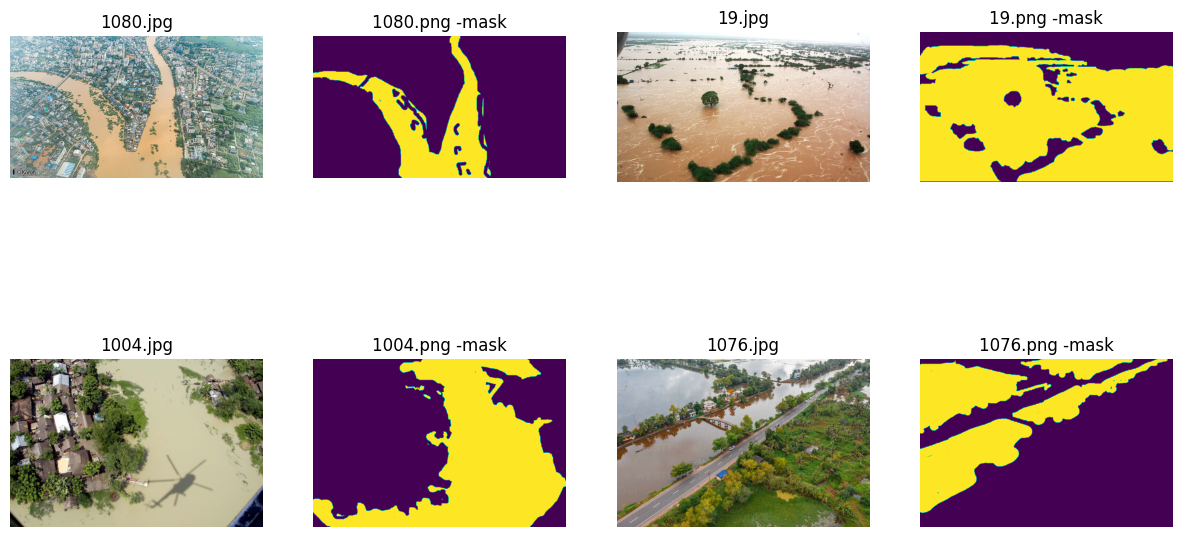

In [ ]:
show_imgs = 4
idx = np.random.choice(len(df), show_imgs, replace=False)
fig, axes = plt.subplots(show_imgs*2//4, 4, figsize=(15, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    new_i = i//2
    if i % 2 ==0 :
        full_path = df.loc[idx[new_i]]['Image']
        basename = os.path.basename(full_path)
    else:
        full_path = df.loc[idx[new_i]]['Mask']
        basename = os.path.basename(full_path) + ' -mask'
    ax.imshow(plt.imread(full_path))
    ax.set_title(basename)
    ax.set_axis_off()

In [ ]:
train_transforms = A.Compose([
    A.Resize(576, 576),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-15,15), p=0.5),
    # A.Normalize(p=1.0),
    # ToTensorV2(),
    ]
    , is_check_shapes = False
)

test_transforms = A.Compose([
    A.Resize(512, 512),
    # ToTensorV2(),
    ],
    is_check_shapes = False
)

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = np.array(Image.open(self.df.iloc[index]['Image']).convert('RGB'))
        mask = np.array(Image.open(self.df.iloc[index]['Mask']).convert('L'))
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img = img/255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        # print(f'img.shape : {img.shape}')
        # print(f'mask.shape : {mask.shape}')
        sample = {'x': img, 'y': target}
        return sample

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_df, val_df = train_test_split(df, test_size=0.2,random_state=9898)
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print(f'len train: {len(train_df)}')
print(f'len val: {len(val_df)}')

len train: 232
len val: 58


In [ ]:
class_size = 1
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=class_size,                      # model output channels (number of classes in your dataset)
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model(torch.randn((1,3,512,512))).shape

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 86.1MB/s]


torch.Size([1, 1, 512, 512])

In [ ]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train() # to training mode.
    epoch_loss = 0
    epoch_iou_score = 0
    for batch_i, batch in enumerate(dataloader):
        x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        epoch_loss += loss.item() # tensor -> python value
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)
        y = y.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        # print(f'train_acc: {acc}')
        epoch_iou_score += iou_score
        lr_scheduler.step()
    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_iou_score/num_batches
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss = 0
    epoch_iou_score = 0
    # No gradient for test data
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            # print(f'val_acc: {acc}')
            epoch_iou_score += iou_score
            # size += y.shape[0]
    return epoch_loss/num_batches, epoch_iou_score/num_batches

In [ ]:
EPOCHS = 2
logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")

loss_fn = smp.losses.DiceLoss(mode="binary")

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 200, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = test(val_loader, model, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)


    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')

    # On epoch end
    torch.save(model.state_dict(), "checkpoints/last.pth")
    # check improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH: 001     train_loss: 0.2676, val_loss: 0.2711     train_iou_score: 0.632, val_iou_score: 0.590     lr: 0.001


 50%|█████     | 1/2 [37:25<37:25, 2245.65s/it]

EPOCH: 002     train_loss: 0.2040, val_loss: 0.2093     train_iou_score: 0.677, val_iou_score: 0.665     lr: 0.001


100%|██████████| 2/2 [1:05:18<00:00, 1959.17s/it]
